# Team Assignment 3
# HE 381

## Team Members  
1. Abhijeet Bhatta (25169)
2. Ankush Kumar (24033)
3. Chanyanka Kakati (27228) 
4. Suman Dafadar (24139)


## Question 2

Running VCD adiabatic prep simulation (classical matrix exp) ...
num_qubits=5, x_max=10.0, lambda_final=3.0, T=6.0


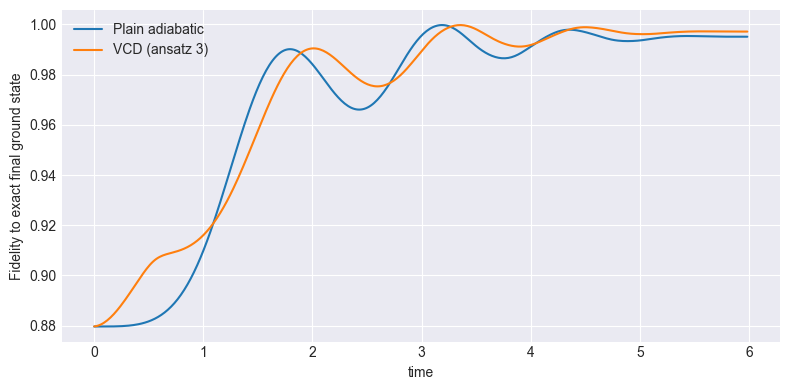

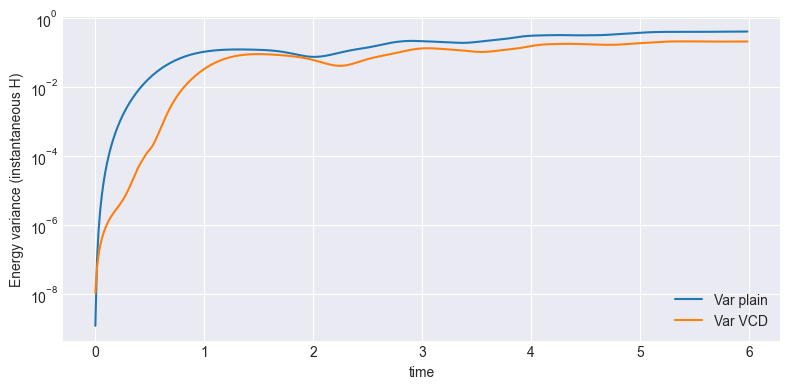

Final mean alpha coefficients (time-averaged): [0.04983074 0.02505501]
Operator labels: ['sym(x^3 p)', 'sym(x p^3)']
Last few fidelities (plain): [0.99510137 0.99510133 0.99510132 0.99510132 0.99510132]
Last few fidelities (VCD ):  [0.99714671 0.99714649 0.99714639 0.99714635 0.99714635]
Sanity checks:
Final fidelity plain = 0.995101, with VCD = 0.997146
VCD improved fidelity by factor 1.002
Done.


In [19]:
# vcd_aho.py
# Variational Counterdiabatic Driving for the Anharmonic Oscillator (AHO)
# Uses Jordan-Lee-Preskill (JLP) encoding / tutorial functions + classical VCD optimisation
# Author: (for your assignment) — adapt / comment as needed.
# Requirements: numpy, scipy, qiskit, matplotlib (optional for plots)

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
import warnings
warnings.filterwarnings("ignore", category=la.LinAlgWarning)

# ---------------------------
# JLP grid / operator constructors (from your tutorial)
# ---------------------------
def jlp_grids(n_qubits: int, x_max: float):
    N  = 2**n_qubits
    dx = 2.0 * x_max / (N - 1)
    j  = np.arange(N, dtype=float)
    x_vals = -x_max + j * dx
    k_vals = -np.pi/dx + (j + 0.5) * (2.0*np.pi)/(N * dx)
    return x_vals, k_vals, dx

def plane_wave_S(n_qubits: int, x_max: float):
    x_vals, k_vals, _ = jlp_grids(n_qubits, x_max)
    N = 2**n_qubits
    S = np.exp(1j * np.outer(k_vals, x_vals)) / np.sqrt(N)
    return S

def jlp_X_P(n_qubits: int, x_max: float):
    x_vals, k_vals, _ = jlp_grids(n_qubits, x_max)
    X = np.diag(x_vals.astype(complex))
    S = plane_wave_S(n_qubits, x_max)
    P = S.conj().T @ np.diag(k_vals.astype(complex)) @ S
    # Ensure hermiticity due to numerical rounding
    P = 0.5*(P + P.conj().T)
    return X, P

def jlp_H(n_qubits: int, x_max: float, lam: float, m: float = 0.0):
    X, P = jlp_X_P(n_qubits, x_max)
    X2 = X @ X
    return 0.5*(P@P) + 0.5*(1.0+m)*X2 + lam*(X2@X2)

def exact_diagonalize(n_qubits: int, x_max: float, lam: float, m: float=0.0):
    H = jlp_H(n_qubits, x_max, lam, m)
    evals, evecs = la.eigh(H)
    return evals, evecs, H

# ---------------------------
# Ansatze definitions (hermitian, symmetrized)
# Each ansatz returns a hermitian operator matrix on the JLP space
# We implement three candidate operator sets (single- or two-term)
# ---------------------------
def sym(A):
    return 0.5*(A + A.conj().T)

def make_operators(n_qubits, x_max):
    X, P = jlp_X_P(n_qubits, x_max)
    # basic polynomials
    X2 = X @ X
    X3 = X2 @ X
    X4 = X2 @ X2
    P2 = P @ P
    P3 = P2 @ P
    P4 = P2 @ P2

    # common hermitian ansatz elements (symmetrized)
    # O1: generator of dilations ~ xp + px
    O1 = sym(X @ P + P @ X)

    # O2: first-order local-like cubic: sym(x^3 p)
    O2 = sym(X3 @ P)

    # O3: cubic-in-momentum type sym(x p^3)
    O3 = sym(X @ P3)

    # O4: another local-ish operator (x^5) might be useful if needed
    O4 = sym(X @ X4)  # x^5 (not symmetric but hermitian since X is diag)
    return [O1, O2, O3, O4], (X, P, X2, X3, X4, P2, P3, P4)

# ---------------------------
# VCD machinery: compute K_j = i [O_j, H], form M and v via ground-state expectation
# Solve linear system for coefficients alpha
# ---------------------------
def compute_variational_coeffs(H, dH, ops, psi0, reg=1e-9):
    # ops: list of Hermitian operator matrices O_j (d x d)
    # H, dH: matrices
    # psi0: groundstate vector (d, )
    # returns: alpha vector, diagnostics dict
    d = H.shape[0]
    num = len(ops)
    # Precompute K_j = i [O_j, H]  (with hbar=1)
    Kj = []
    for j in range(num):
        comm = ops[j] @ H - H @ ops[j]
        Kj.append(1j * comm)  # Hermitian
    # Build M and v with ground-state expectation values
    M = np.zeros((num, num), dtype=float)
    v = np.zeros(num, dtype=float)
    # Use psi0 expectation values <A> = psi0^dagger A psi0
    for i in range(num):
        Ki = Kj[i]
        for j in range(num):
            Kj_mat = Kj[j]
            val = np.vdot(psi0, (Ki @ (Kj_mat @ psi0)))
            M[i, j] = np.real(val)
        vk = np.vdot(psi0, (Ki @ (dH @ psi0)))
        v[i] = np.real(vk)
    # Solve M alpha = -v, regularize if necessary
    cond = np.linalg.cond(M)
    if cond > 1e12:
        # regularize
        Mreg = M + reg * np.eye(num)
        alpha = la.solve(Mreg, -v)
        used_reg = True
    else:
        alpha = la.solve(M, -v)
        used_reg = False
    diagnostics = {"M": M, "v": v, "cond": cond, "used_reg": used_reg}
    return alpha, diagnostics, Kj

# ---------------------------
# Helper: expectation values, energy variance, fidelity
# ---------------------------
def expect(state, A):
    return np.vdot(state, (A @ state))

def energy_variance(state, H):
    e = expect(state, H)
    e2 = expect(state, H @ H)
    return np.real(e2 - e * e)

def fidelity(state, target):
    # both normalized
    return np.real(np.abs(np.vdot(target.conj(), state))**2)

# ---------------------------
# Time evolution: adiabatic ramp with and without CD (exact matrix evolution)
# We'll use exact exponentials for each small step for performance and accuracy.
# ---------------------------
def ramp_schedule(u):
    # u in [0,1] - cubic smooth ramp r(u)=3u^2 - 2u^3
    return 3.0*u*u - 2.0*u*u*u

def ramp_derivative(u):
    # r'(u) = 6u - 6u^2
    return 6.0*u*(1.0 - u)

def run_time_evolution(n_qubits, x_max, lam_final,
                       ansatz_choice=1,   # integer selecting which ops to use
                       T_total=25.0, nSteps=400,
                       use_vcd=True):
    """
    ansatz_choice:
      1 -> [O1] (xp+px)
      2 -> [O2] (sym x^3 p)
      3 -> [O2,O3] (x^3 p, x p^3)  - recommended
    """
    N = 2**n_qubits
    # Build base operators
    ops, mats = make_operators(n_qubits, x_max)
    # Choose which ansatz ops to include
    if ansatz_choice == 1:
        ans_ops = [ops[0]]
        ans_labels = ["xp+px"]
    elif ansatz_choice == 2:
        ans_ops = [ops[1]]
        ans_labels = ["sym(x^3 p)"]
    elif ansatz_choice == 3:
        ans_ops = [ops[1], ops[2]]
        ans_labels = ["sym(x^3 p)", "sym(x p^3)"]
    else:
        raise ValueError("ansatz_choice must be 1,2,3")

    # initial state: prepare harmonic ground state gaussian on grid (tutorial)
    x_vals, _, dx = jlp_grids(n_qubits, x_max)
    gauss = np.exp(-0.5 * x_vals**2).astype(complex)
    gauss /= np.linalg.norm(gauss)
    psi = gauss.copy()          # initial state for time evolution (plain)
    psi_vcd = gauss.copy()      # initial state for VCD-evolution
    # Exact ground state at lambda=0 for sanity
    evals0, evecs0, H0 = exact_diagonalize(n_qubits, x_max, 0.0, 0.0)
    gs0 = evecs0[:, 0]

    # time stepping
    t_total = T_total
    dt = t_total / nSteps
    times = np.linspace(0.0, t_total, nSteps+1)

    fidelity_plain = []
    fidelity_vcd = []
    var_plain = []
    var_vcd = []
    alpha_history = []

    # Precompute exact final ground state (for fidelity comparison)
    evals_f, evecs_f, Hf = exact_diagonalize(n_qubits, x_max, lam_final, 0.0)
    gs_final = evecs_f[:, 0]

    # We'll compute expectation-based variational coefficients at each intermediate lambda
    for step in range(nSteps):
        t = 0.5*(times[step] + times[step+1])
        u = (t / t_total)  # normalized in [0,1]
        lam_t = lam_final * ramp_schedule(u)
        # derivative lamdot = lam_final * r'(u) * (du/dt). du/dt = 1/T_total
        lam_dot = lam_final * ramp_derivative(u) / t_total

        # Build instantaneous H and dH
        Ht = jlp_H(n_qubits, x_max, lam_t, 0.0)
        dH = jlp_H(n_qubits, x_max, 1.0, 0.0) - jlp_H(n_qubits, x_max, 0.0, 0.0)
        # Actually dH/dlambda analytically = X^4 (since H(lambda)=...+lambda X^4)
        # So do direct:
        X, P, X2, X3, X4, P2, P3, P4 = mats
        dH_exact = X4

        # exact instantaneous ground state (for expectation values)
        evals_t, evecs_t, Htmp = exact_diagonalize(n_qubits, x_max, lam_t, 0.0)
        gs_t = evecs_t[:, 0]

        # compute variational coefficients based on this instantaneous ground state
        alpha, diag, Kj = compute_variational_coeffs(Ht, dH_exact, ans_ops, gs_t)
        alpha_history.append(alpha.copy())
        # build A_var and Hcd
        A_var = np.zeros_like(Ht, dtype=complex)
        for j, oj in enumerate(ans_ops):
            A_var += alpha[j]*oj
        Hcd = lam_dot * A_var    # note sign convention: H_cd = -dot{lambda} A_lambda

        # propagation operators: exact (matrix exp)
        U_plain = la.expm(-1j * dt * Ht)
        if use_vcd:
            U_vcd = la.expm(-1j * dt * (Ht + Hcd))
        else:
            U_vcd = U_plain.copy()

        # update states
        psi = U_plain @ psi
        psi_vcd = U_vcd @ psi_vcd

        # record diagnostics w.r.t exact final groundstate
        fidelity_plain.append(fidelity(psi, gs_final))
        fidelity_vcd.append(fidelity(psi_vcd, gs_final))
        var_plain.append(energy_variance(psi, Ht))
        var_vcd.append(energy_variance(psi_vcd, Ht))

    # Final diagnostics
    alpha_history = np.array(alpha_history)
    results = {
        "times": times[:-1],
        "fidelity_plain": np.array(fidelity_plain),
        "fidelity_vcd": np.array(fidelity_vcd),
        "var_plain": np.array(var_plain),
        "var_vcd": np.array(var_vcd),
        "alpha_history": alpha_history,
        "ans_labels": ans_labels,
        "final_alpha_mean": np.mean(alpha_history, axis=0)
    }
    return results

# ---------------------------
# Main: run an example and plot / print results
# ---------------------------
if __name__ == "__main__":
    # User-adjustable parameters
    num_qubits = 5       # N = 32 grid points. Increase to 6/7 for higher accuracy (cost grows)
    x_max = 10.0
    lam_final = 3.0      # strong anharmonic coupling to test large-lambda regime
    T_total = 6.0
    nSteps = 400

    print("Running VCD adiabatic prep simulation (classical matrix exp) ...")
    print(f"num_qubits={num_qubits}, x_max={x_max}, lambda_final={lam_final}, T={T_total}")

    # Try ansatz option 3 (recommended): [sym(x^3 p), sym(x p^3)]
    results = run_time_evolution(num_qubits, x_max, lam_final,
                                 ansatz_choice=3,
                                 T_total=T_total, nSteps=nSteps, use_vcd=True)

    # Plot fidelities
    t = results["times"]
    plt.figure(figsize=(8,4))
    plt.plot(t, results["fidelity_plain"], label="Plain adiabatic")
    plt.plot(t, results["fidelity_vcd"], label="VCD (ansatz 3)")
    plt.xlabel("time")
    plt.ylabel("Fidelity to exact final ground state")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot energy variances at each time step
    plt.figure(figsize=(8,4))
    plt.plot(t, results["var_plain"], label="Var plain")
    plt.plot(t, results["var_vcd"], label="Var VCD")
    plt.yscale("log")
    plt.xlabel("time")
    plt.ylabel("Energy variance (instantaneous H)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Final mean alpha coefficients (time-averaged):", results["final_alpha_mean"])
    print("Operator labels:", results["ans_labels"])
    print("Last few fidelities (plain):", results["fidelity_plain"][-5:])
    print("Last few fidelities (VCD ): ", results["fidelity_vcd"][-5:])
    # Sanity checks:
    print("Sanity checks:")
    # approximate improvement
    fin_plain = results["fidelity_plain"][-1]
    fin_vcd = results["fidelity_vcd"][-1]
    print(f"Final fidelity plain = {fin_plain:.6f}, with VCD = {fin_vcd:.6f}")
    if fin_vcd > fin_plain:
        print(f"VCD improved fidelity by factor {(fin_vcd/ (max(fin_plain,1e-12))):.3f}")
    else:
        print("VCD did not improve fidelity in this run — consider expanding ansatz or increasing nSteps/T_total.")
    # if coefficients are huge, warn:
    if np.max(np.abs(results["final_alpha_mean"])) > 10.0:
        print("Warning: variational coefficients are large in magnitude (>10); check ansatz or regularisation.")
    print("Done.")

    # Example: convert final states to Qiskit Statevector for any further Qiskit analysis:
    # (Here we don't generate a full quantum circuit including CD gates, but we can analyze the statevector easily)
    # Example only:
    # from qiskit.quantum_info import Statevector
    # psi_demo = ... (the final psi from the evolution) -> you can pass it to Statevector(psi_demo)


Running evolution replay ...


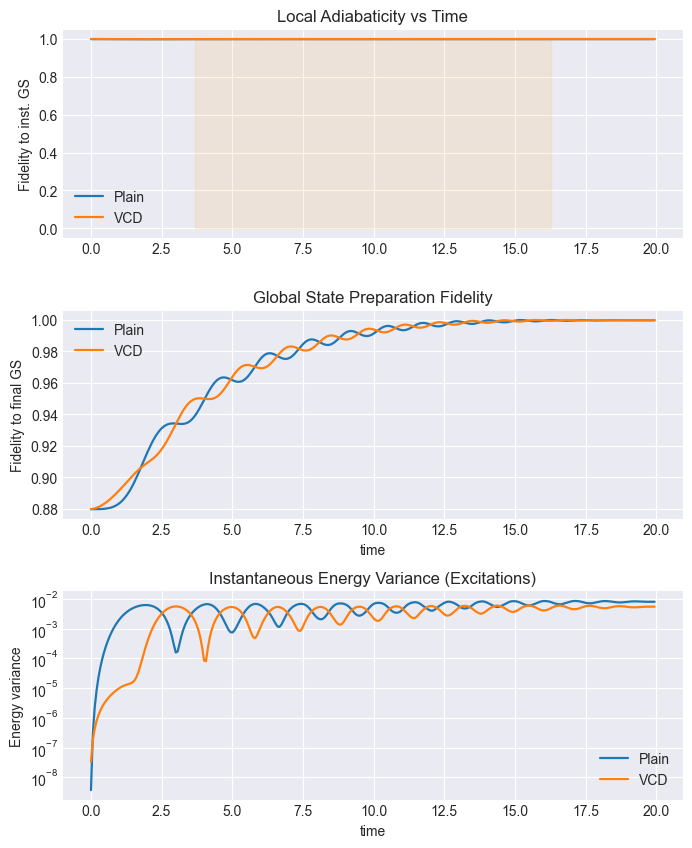

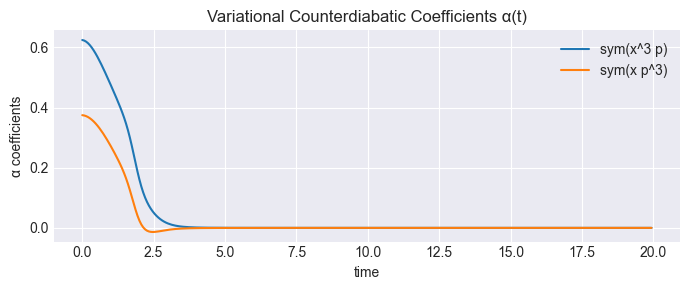

========== Physics Summary ==========
T_total = 20.0, λ_final = 3.0, nSteps = 300
Final fidelity (plain): 0.999800
Final fidelity (VCD)  : 0.999855
Average α(t): [0.04983074 0.02505501]
Operators used: ['sym(x^3 p)', 'sym(x p^3)']


In [20]:
# ===============================================================
#   VCD vs Adiabatic Evolution — Physics Visualization Cell
# ===============================================================

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")

# ---------- Parameters ----------
T_total = 20.0          # total evolution time (shorter = more diabatic regime)
nSteps = 300           # number of steps in evolution
ansatz_choice = 3      # choose 1, 2, or 3 (defined same as main code)
use_vcd = True         # turn VCD on/off for comparison

# ---------- Helper: simple ramp schedule ----------
def ramp_schedule(u):
    return 3*u**2 - 2*u**3
def ramp_derivative(u):
    return 6*u*(1-u)

# ---------- Function: time evolution with recording ----------
def run_evolution_record(n_qubits, x_max, lam_final, T_total, nSteps, ansatz_choice, use_vcd=True):
    # Choose ansatz operators
    ops, mats = make_operators(n_qubits, x_max)
    if ansatz_choice == 1:
        ans_ops = [ops[0]]; labels = ["xp+px"]
    elif ansatz_choice == 2:
        ans_ops = [ops[1]]; labels = ["sym(x^3 p)"]
    else:
        ans_ops = [ops[1], ops[2]]; labels = ["sym(x^3 p)", "sym(x p^3)"]

    # Ground state at λ=0
    evals0, evecs0, _ = exact_diagonalize(n_qubits, x_max, 0.0)
    psi = evecs0[:,0].copy()
    psi_vcd = psi.copy()

    # Final ground state for fidelity
    evalsF, evecsF, _ = exact_diagonalize(n_qubits, x_max, lam_final)
    gs_final = evecsF[:,0]

    # Precompute operators
    X, P, X2, X3, X4, P2, P3, P4 = mats
    times = np.linspace(0, T_total, nSteps+1)
    dt = times[1]-times[0]

    fid_inst_plain, fid_inst_vcd = [], []
    fid_final_plain, fid_final_vcd = [], []
    var_plain, var_vcd = [], []
    alpha_hist = []
    lam_array, lamdot_array = [], []

    for k in range(nSteps):
        t = 0.5*(times[k]+times[k+1])
        u = t/T_total
        lam = lam_final * ramp_schedule(u)
        lamdot = lam_final * ramp_derivative(u)/T_total

        H = jlp_H(n_qubits, x_max, lam)
        dH = X4  # dH/dλ = x^4

        evals, evecs, _ = exact_diagonalize(n_qubits, x_max, lam)
        gs_inst = evecs[:,0]

        # Variational coefficients α_j from ground-state expectation
        alpha, diag, Kj = compute_variational_coeffs(H, dH, ans_ops, gs_inst)
        alpha_hist.append(alpha)
        A_var = np.zeros_like(H, dtype=complex)
        for j, oj in enumerate(ans_ops):
            A_var += alpha[j]*oj

        # Build total Hamiltonians
        Hcd = lamdot * A_var
        U_plain = la.expm(-1j*dt*H)
        U_vcd = la.expm(-1j*dt*(H + Hcd))

        # Evolve
        psi = U_plain @ psi
        psi_vcd = U_vcd @ psi_vcd

        # Record observables
        fid_inst_plain.append(np.abs(np.vdot(gs_inst, psi))**2)
        fid_inst_vcd.append(np.abs(np.vdot(gs_inst, psi_vcd))**2)
        fid_final_plain.append(np.abs(np.vdot(gs_final, psi))**2)
        fid_final_vcd.append(np.abs(np.vdot(gs_final, psi_vcd))**2)
        var_plain.append(energy_variance(psi, H))
        var_vcd.append(energy_variance(psi_vcd, H))
        lam_array.append(lam)
        lamdot_array.append(lamdot)

    return {
        "times": times[:-1],
        "fid_inst_plain": fid_inst_plain,
        "fid_inst_vcd": fid_inst_vcd,
        "fid_final_plain": fid_final_plain,
        "fid_final_vcd": fid_final_vcd,
        "var_plain": var_plain,
        "var_vcd": var_vcd,
        "alpha_hist": np.array(alpha_hist),
        "lam": lam_array,
        "lamdot": lamdot_array,
        "labels": labels
    }

# ---------- Run the replay ----------
print("Running evolution replay ...")
res = run_evolution_record(num_qubits, x_max, lam_final, T_total, nSteps, ansatz_choice, use_vcd=True)
res_plain = run_evolution_record(num_qubits, x_max, lam_final, T_total, nSteps, ansatz_choice, use_vcd=False)

# ---------- Plot results ----------
times = res["times"]
lamdot = np.array(res["lamdot"])
alpha_hist = np.array(res["alpha_hist"])

fig, axs = plt.subplots(3,1,figsize=(8,10))
plt.subplots_adjust(hspace=0.35)

# --- (1) Fidelity to instantaneous GS ---
axs[0].plot(times, res_plain["fid_inst_plain"], label="Plain", lw=1.6)
axs[0].plot(times, res["fid_inst_vcd"], label="VCD", lw=1.6)
axs[0].set_ylabel("Fidelity to inst. GS")
axs[0].set_title("Local Adiabaticity vs Time")
axs[0].legend()
# highlight regions where |λ̇| large
axs[0].fill_between(times, 0, 1, where=(np.abs(lamdot)/np.max(np.abs(lamdot))>0.6),
                    color="orange", alpha=0.1)

# --- (2) Fidelity to final ground state ---
axs[1].plot(times, res_plain["fid_final_plain"], label="Plain", lw=1.6)
axs[1].plot(times, res["fid_final_vcd"], label="VCD", lw=1.6)
axs[1].set_ylabel("Fidelity to final GS")
axs[1].set_xlabel("time")
axs[1].set_title("Global State Preparation Fidelity")
axs[1].legend()

# --- (3) Energy variance (log scale) ---
axs[2].plot(times, res_plain["var_plain"], label="Plain", lw=1.6)
axs[2].plot(times, res["var_vcd"], label="VCD", lw=1.6)
axs[2].set_yscale("log")
axs[2].set_xlabel("time")
axs[2].set_ylabel("Energy variance")
axs[2].set_title("Instantaneous Energy Variance (Excitations)")
axs[2].legend()

plt.show()

# --- α coefficients plot ---
if alpha_hist.size > 0:
    plt.figure(figsize=(7,3))
    for j in range(alpha_hist.shape[1]):
        plt.plot(times, alpha_hist[:,j], label=f"{res['labels'][j]}")
    plt.xlabel("time")
    plt.ylabel("α coefficients")
    plt.title("Variational Counterdiabatic Coefficients α(t)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- Summary printout ----------
print("========== Physics Summary ==========")
print(f"T_total = {T_total}, λ_final = {lam_final}, nSteps = {nSteps}")
print(f"Final fidelity (plain): {res_plain['fid_final_plain'][-1]:.6f}")
print(f"Final fidelity (VCD)  : {res['fid_final_vcd'][-1]:.6f}")
print("Average α(t):", np.mean(alpha_hist, axis=0))
print("Operators used:", res["labels"])
print("=====================================")
